# 10__snps
# finding regulatory SNPs in MPRA data

in this notebook, i call regulatory SNPs by comparing the barcode activities for a reference tile to the barcode activities for the alternative tile. i do this per replicate and then combine the p-values and adjust them (see supplemental methods).

------

figures in this notebook:
- **Fig S19**: volcano plots in HepG2 & K562
- **Fig S16**: control SNP swarm plots in HepG2 & K562
- **Fig S22**: GWAS SNP swarm plots in HepG2 & K562
- **Fig 5B and S18**: scatter plots between number of motifs predicted to be disrupted by FIMO and SNP effect sizes in HepG2 and K562
- **Fig 4C**: scatter plot showing effect size differences between HepG2 & K562
- **Fig S21**: boxplot showing effect sizes across biotypes

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
import time

from decimal import Decimal
from scipy import stats
from scipy.stats import spearmanr
from statsmodels.sandbox.stats import multicomp

# import utils
sys.path.append("../../utils")
from plotting_utils import *
from misc_utils import *
from norm_utils import *
from snp_utils import *

%matplotlib inline

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE
np.random.seed(SEED)

## variables

In [3]:
index_dir = "../../data/00__index"
activ_dir = "../../data/02__activs"
pval_dir = "../../data/03__pvals"

In [4]:
pool1_index_f = "%s/tss_oligo_pool.index.txt" % index_dir
pool2_index_f = "%s/dels_oligo_pool.index.txt" % index_dir

In [5]:
hepg2_pool1_activ_f = "%s/POOL1__pMPRA1__HepG2__activities_per_barcode.txt" % activ_dir
k562_pool1_activ_f = "%s/POOL1__pMPRA1__K562__activities_per_barcode.txt" % activ_dir
hepg2_pool2_activ_f = "%s/POOL2__pMPRA1__HepG2__activities_per_barcode.txt" % activ_dir
k562_pool2_activ_f = "%s/POOL2__pMPRA1__K562__activities_per_barcode.txt" % activ_dir

In [6]:
hepg2_pool1_pvals_f = "%s/POOL1__pMPRA1__HepG2__pvals.txt" % pval_dir
k562_pool1_pvals_f = "%s/POOL1__pMPRA1__K562__pvals.txt" % pval_dir
hepg2_pool2_pvals_f = "%s/POOL2__pMPRA1__HepG2__pvals.txt" % pval_dir
k562_pool2_pvals_f = "%s/POOL2__pMPRA1__K562__pvals.txt" % pval_dir

In [7]:
# number of times to downsample hepg2
n_samples = 100

In [8]:
fimo_f = "../../misc/05__fimo/pool1.seqID_NumMotif.txt"

In [9]:
annot_f = "../../misc/00__tss_properties/correspondance_seqID_PromType_unique.txt"

## 1. import data

In [10]:
pool1_index = pd.read_table(pool1_index_f, sep="\t")
pool2_index = pd.read_table(pool2_index_f, sep="\t")

In [11]:
hepg2_pool1_activ = pd.read_table(hepg2_pool1_activ_f, sep="\t")
k562_pool1_activ = pd.read_table(k562_pool1_activ_f, sep="\t")
hepg2_pool2_activ = pd.read_table(hepg2_pool2_activ_f, sep="\t")
k562_pool2_activ = pd.read_table(k562_pool2_activ_f, sep="\t")

In [12]:
hepg2_pool1_reps = [x for x in hepg2_pool1_activ.columns if x != "barcode"]
k562_pool1_reps = [x for x in k562_pool1_activ.columns if x != "barcode"]
hepg2_pool2_reps = [x for x in hepg2_pool2_activ.columns if x != "barcode"]
k562_pool2_reps = [x for x in k562_pool2_activ.columns if x != "barcode"]

hepg2_pool1_activ["rep_mean"] = np.nanmean(hepg2_pool1_activ[hepg2_pool1_reps], axis=1)
k562_pool1_activ["rep_mean"] = np.nanmean(k562_pool1_activ[k562_pool1_reps], axis=1)
hepg2_pool2_activ["rep_mean"] = np.nanmean(hepg2_pool2_activ[hepg2_pool2_reps], axis=1)
k562_pool2_activ["rep_mean"] = np.nanmean(k562_pool2_activ[k562_pool2_reps], axis=1)

hepg2_pool1_activ.head()

,barcode,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10,rna_11,rna_12,rna_13,rna_14,rep_mean
0,AAAACAAAGTC,-0.232915,-0.409743,-0.830252,-0.558582,0.259745,0.471566,0.137889,0.605610,-0.115982,0.389549,0.251261,0.360733,0.027407
1,AAAACAAAGTT,-1.641943,-1.786002,NaN,NaN,NaN,-1.472057,-2.748240,0.123337,-3.569422,-0.959375,-2.188633,-1.877116,-1.791050
2,AAAACAAATGT,0.445553,0.331374,0.022147,-0.308519,0.782481,0.935864,0.411982,0.688970,0.972243,0.836551,0.892322,0.819801,0.569231
3,AAAACAACGTC,-0.010666,1.834886,1.047326,-0.196539,0.456452,0.568126,0.930430,1.951003,0.654473,1.429290,2.026544,1.170410,0.988478
4,AAAACAACGTG,0.339223,0.864835,-1.879958,-0.186074,0.235210,-1.084751,1.190649,1.043910,-1.136628,0.028256,0.408414,0.148594,-0.002360


In [13]:
pool1_index_elem = pool1_index[["oligo_type", "dupe_info", "seq_name", "tile_name", "chr", "locus_start", "locus_end",
                                "strand", "element", "unique_id", "SNP"]].drop_duplicates()
pool2_index_elem = pool2_index[["oligo_type", "dupe_info", "seq_name", "tile_name", "chr", "locus_start", "locus_end",
                                "strand", "element", "unique_id", "SNP"]].drop_duplicates()

In [14]:
hepg2_pool1_pvals = pd.read_table(hepg2_pool1_pvals_f, sep="\t")
k562_pool1_pvals = pd.read_table(k562_pool1_pvals_f, sep="\t")
hepg2_pool2_pvals = pd.read_table(hepg2_pool2_pvals_f, sep="\t")
k562_pool2_pvals = pd.read_table(k562_pool2_pvals_f, sep="\t")

In [15]:
fimo = pd.read_table(fimo_f, sep="\t", header=None)
fimo.columns = ["seqID", "n_motifs"]
fimo.head()

,seqID,n_motifs
0,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,10
1,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,50
2,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,24
3,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,12
4,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,16


In [16]:
annot = pd.read_table(annot_f, sep="\t")
annot.head()

,seqID,PromType2
0,WILDTYPE__Antisense.noflip.NA__chr1:100435456....,div_lnc
1,WILDTYPE__Lincrna.flip.sense__chr1:100731637.....,div_lnc
2,FLIPPED__Lincrna.flip.antisense__chr1:10073163...,div_lnc
3,FLIPPED__mrna.flip.antisense__chr1:100731714.....,div_pc
4,WILDTYPE__mrna.flip.sense__chr1:100731714..100...,div_pc


## 2. merge w/ index

In [17]:
hepg2_pool1_data = pool1_index.merge(hepg2_pool1_activ, on="barcode", how="outer")
k562_pool1_data = pool1_index.merge(k562_pool1_activ, on="barcode", how="outer")
hepg2_pool2_data = pool2_index.merge(hepg2_pool2_activ, on="barcode", how="outer")
k562_pool2_data = pool2_index.merge(k562_pool2_activ, on="barcode", how="outer")
hepg2_pool1_data.head()

,full_oligo,oligo_type,oligo_id,dupe_info,seq_name,tile_name,chr,locus_start,locus_end,strand,...,rna_6,rna_7,rna_8,rna_9,rna_10,rna_11,rna_12,rna_13,rna_14,rep_mean
0,ACTGGCCGCTTCACTGGTGCAGCCCAGGCGTTTCCGGGTTCCCGCG...,WILDTYPE,1.1.0.0.1,none,"Antisense.noflip.NA__chr1:100435456..100435570,-",Antisense.noflip.NA__chr1:100435456..100435570...,chr1,100435456.0,100435570.0,-,...,1.770474,1.895198,1.878385,1.933633,2.220131,1.960955,1.973998,1.990893,2.121866,2.013580
1,ACTGGCCGCTTCACTGGTGCAGCCCAGGCGTTTCCGGGTTCCCGCG...,WILDTYPE,1.1.0.0.2,none,"Antisense.noflip.NA__chr1:100435456..100435570,-",Antisense.noflip.NA__chr1:100435456..100435570...,chr1,100435456.0,100435570.0,-,...,1.903111,1.733053,1.594202,1.724073,1.804927,1.627770,1.753076,1.677350,1.972532,1.728979
2,ACTGGCCGCTTCACTGGTGCAGCCCAGGCGTTTCCGGGTTCCCGCG...,WILDTYPE,1.1.0.0.3,none,"Antisense.noflip.NA__chr1:100435456..100435570,-",Antisense.noflip.NA__chr1:100435456..100435570...,chr1,100435456.0,100435570.0,-,...,1.098191,1.308489,1.409376,1.769699,1.729734,1.432375,1.585704,1.384201,1.684251,1.505785
3,ACTGGCCGCTTCACTGGTGCAGCCCAGGCGTTTCCGGGTTCCCGCG...,WILDTYPE,1.1.0.0.4,none,"Antisense.noflip.NA__chr1:100435456..100435570,-",Antisense.noflip.NA__chr1:100435456..100435570...,chr1,100435456.0,100435570.0,-,...,1.653971,1.756965,1.772167,1.389426,1.887075,1.648490,1.716837,1.679619,1.670818,1.695738
4,ACTGGCCGCTTCACTGGTGCAGCCCAGGCGTTTCCGGGTTCCCGCG...,WILDTYPE,1.1.0.0.5,none,"Antisense.noflip.NA__chr1:100435456..100435570,-",Antisense.noflip.NA__chr1:100435456..100435570...,chr1,100435456.0,100435570.0,-,...,0.909410,1.529894,1.110386,2.122635,1.330243,1.268685,0.992613,2.040454,0.431626,1.361815


## 3. extract SNP pairs

create map of wt unique_id : snp unique_ids

In [18]:
hepg2_pool1_wt_w_snp_seqs = hepg2_pool1_data[hepg2_pool1_data["oligo_type"].isin(["WILDTYPE_BUT_HAS_SNP", 
                                                                                  "CONTROL_BUT_HAS_SNP"])]
k562_pool1_wt_w_snp_seqs = k562_pool1_data[k562_pool1_data["oligo_type"].isin(["WILDTYPE_BUT_HAS_SNP", 
                                                                               "CONTROL_BUT_HAS_SNP"])]
hepg2_pool2_wt_w_snp_seqs = hepg2_pool2_data[hepg2_pool2_data["oligo_type"].isin(["WILDTYPE_BUT_HAS_SNP", 
                                                                                  "CONTROL_BUT_HAS_SNP"])]
k562_pool2_wt_w_snp_seqs = k562_pool2_data[k562_pool2_data["oligo_type"].isin(["WILDTYPE_BUT_HAS_SNP", 
                                                                               "CONTROL_BUT_HAS_SNP"])]

In [19]:
hepg2_pool1_wt_w_snp_seqs = hepg2_pool1_wt_w_snp_seqs[["oligo_type", "dupe_info", "seq_name", "tile_name", "chr", 
                                                       "locus_start", "locus_end", "strand", "element", "unique_id", 
                                                       "SNP"]].drop_duplicates()
k562_pool1_wt_w_snp_seqs = k562_pool1_wt_w_snp_seqs[["oligo_type", "dupe_info", "seq_name", "tile_name", "chr", 
                                                     "locus_start", "locus_end", "strand", "element", "unique_id", 
                                                     "SNP"]].drop_duplicates()
hepg2_pool2_wt_w_snp_seqs = hepg2_pool2_wt_w_snp_seqs[["oligo_type", "dupe_info", "seq_name", "tile_name", "chr", 
                                                       "locus_start", "locus_end", "strand", "element", "unique_id", 
                                                       "SNP"]].drop_duplicates()
k562_pool2_wt_w_snp_seqs = k562_pool2_wt_w_snp_seqs[["oligo_type", "dupe_info", "seq_name", "tile_name", "chr", 
                                                     "locus_start", "locus_end", "strand", "element", "unique_id", 
                                                     "SNP"]].drop_duplicates()

In [20]:
hepg2_pool1_wt_df = hepg2_pool1_wt_w_snp_seqs.copy()
k562_pool1_wt_df = k562_pool1_wt_w_snp_seqs.copy()
hepg2_pool2_wt_df = hepg2_pool2_wt_w_snp_seqs.copy()
k562_pool2_wt_df = k562_pool2_wt_w_snp_seqs.copy()

In [21]:
print("mapping HepG2 pool1 SNPs")
hepg2_pool1_snp_map = map_snps(hepg2_pool1_wt_w_snp_seqs, pool1_index_elem)
print("mapping K562 pool1 SNPs")
k562_pool1_snp_map = map_snps(k562_pool1_wt_w_snp_seqs, pool1_index_elem)
print("mapping HepG2 pool2 SNPs")
hepg2_pool2_snp_map = map_snps(hepg2_pool2_wt_w_snp_seqs, pool2_index_elem)
print("mapping K562 pool2 SNPs")
k562_pool2_snp_map = map_snps(k562_pool2_wt_w_snp_seqs, pool2_index_elem)

mapping HepG2 pool1 SNPs
mapping K562 pool1 SNPs
mapping HepG2 pool2 SNPs
mapping K562 pool2 SNPs


## 4. calculate p-values (wilcox test using mean across replicates, 1 for each barcode)

In [22]:
hepg2_pool1_log2fc_cols = [x for x in hepg2_pool1_pvals.columns if "_log2fc" in x]
k562_pool1_log2fc_cols = [x for x in k562_pool1_pvals.columns if "_log2fc" in x]
hepg2_pool2_log2fc_cols = [x for x in hepg2_pool2_pvals.columns if "_log2fc" in x]
k562_pool2_log2fc_cols = [x for x in k562_pool2_pvals.columns if "_log2fc" in x]

In [23]:
hepg2_pool1_pvals["mean_log2fc"] = hepg2_pool1_pvals[hepg2_pool1_log2fc_cols].mean(axis=1)
k562_pool1_pvals["mean_log2fc"] = k562_pool1_pvals[k562_pool1_log2fc_cols].mean(axis=1)
hepg2_pool2_pvals["mean_log2fc"] = hepg2_pool2_pvals[hepg2_pool2_log2fc_cols].mean(axis=1)
k562_pool2_pvals["mean_log2fc"] = k562_pool2_pvals[k562_pool2_log2fc_cols].mean(axis=1)

note if HepG2 -- to compare to other cell types, downsample to 4 reps. do this 100x and take minimum.

### active

In [24]:
min_barcodes = 20
activ_alpha = 0.5
active_l2fc_thresh = 0.5
repr_l2fc_thresh = -0.5

In [25]:
k562_pool1_active_snp_data = get_snp_results(k562_pool1_reps, k562_pool1_snp_map, k562_pool1_data, k562_pool1_pvals,
                                             min_barcodes, activ_alpha, active_l2fc_thresh, repr_l2fc_thresh, 
                                             "active", "POOL1", 0)

active SNPs, reps: ['rna_1', 'rna_2', 'rna_3', 'rna_4']
...rna_1 pvals...
1783
1783
...rna_2 pvals...
1783
1783
...rna_3 pvals...
1783
1783
...rna_4 pvals...
1783
1783
[]


In [26]:
k562_pool2_active_snp_data = get_snp_results(k562_pool2_reps, k562_pool2_snp_map, k562_pool2_data, k562_pool2_pvals,
                                             min_barcodes, activ_alpha, active_l2fc_thresh, repr_l2fc_thresh, 
                                             "active", "POOL2", 0)

active SNPs, reps: ['rna_1', 'rna_2', 'rna_3', 'rna_4']
...rna_1 pvals...
199
199
...rna_2 pvals...
199
199
...rna_3 pvals...
199
199
...rna_4 pvals...
199
199
[]


In [27]:
hepg2_pool1_active_snp_data = get_snp_results(hepg2_pool1_reps, hepg2_pool1_snp_map, hepg2_pool1_data, hepg2_pool1_pvals,
                                              min_barcodes, activ_alpha, active_l2fc_thresh, repr_l2fc_thresh, 
                                              "active", "POOL1", n_samples)

active SNPs, reps: ['rna_3', 'rna_4', 'rna_5', 'rna_6', 'rna_7', 'rna_8', 'rna_9', 'rna_10', 'rna_11', 'rna_12', 'rna_13', 'rna_14']
...rna_3 pvals...
1783
1783
...rna_4 pvals...
1783
1783
...rna_5 pvals...
1783
1783
...rna_6 pvals...
1783
1783
...rna_7 pvals...
1783
1783
...rna_8 pvals...
1783
1783
...rna_9 pvals...
1783
1783
...rna_10 pvals...
1783
1783
...rna_11 pvals...
1783
1783
...rna_12 pvals...
1783
1783
...rna_13 pvals...
1783
1783
...rna_14 pvals...
1783
1783
['samp_0_combined_padj', 'samp_1_combined_padj', 'samp_2_combined_padj', 'samp_3_combined_padj', 'samp_4_combined_padj', 'samp_5_combined_padj', 'samp_6_combined_padj', 'samp_7_combined_padj', 'samp_8_combined_padj', 'samp_9_combined_padj', 'samp_10_combined_padj', 'samp_11_combined_padj', 'samp_12_combined_padj', 'samp_13_combined_padj', 'samp_14_combined_padj', 'samp_15_combined_padj', 'samp_16_combined_padj', 'samp_17_combined_padj', 'samp_18_combined_padj', 'samp_19_combined_padj', 'samp_20_combined_padj', 'samp_21_c

In [28]:
hepg2_pool2_active_snp_data = get_snp_results(hepg2_pool2_reps, hepg2_pool2_snp_map, hepg2_pool2_data, hepg2_pool2_pvals,
                                              min_barcodes, activ_alpha, active_l2fc_thresh, repr_l2fc_thresh, 
                                              "active", "POOL2", 0)

active SNPs, reps: ['rna_3', 'rna_4', 'rna_5', 'rna_6', 'rna_7', 'rna_8', 'rna_9', 'rna_10']
...rna_3 pvals...
199
199
...rna_4 pvals...
199
199
...rna_5 pvals...
199
199
...rna_6 pvals...
199
199
...rna_7 pvals...
199
199
...rna_8 pvals...
199
199
...rna_9 pvals...
199
199
...rna_10 pvals...
199
199
[]


### repressive

In [29]:
k562_pool1_repressive_snp_data = get_snp_results(k562_pool1_reps, k562_pool1_snp_map, k562_pool1_data, k562_pool1_pvals,
                                                min_barcodes, activ_alpha, active_l2fc_thresh, repr_l2fc_thresh, 
                                                "repressive", "POOL1", 0)

repressive SNPs, reps: ['rna_1', 'rna_2', 'rna_3', 'rna_4']
...rna_1 pvals...
1783
1783
...rna_2 pvals...
1783
1783
...rna_3 pvals...
1783
1783
...rna_4 pvals...
1783
1783
[]


In [30]:
k562_pool2_repressive_snp_data = get_snp_results(k562_pool2_reps, k562_pool2_snp_map, k562_pool2_data, k562_pool2_pvals,
                                                 min_barcodes, activ_alpha, active_l2fc_thresh, repr_l2fc_thresh, 
                                                 "repressive", "POOL2", 0)

repressive SNPs, reps: ['rna_1', 'rna_2', 'rna_3', 'rna_4']
...rna_1 pvals...
199
199
...rna_2 pvals...
199
199
...rna_3 pvals...
199
199
...rna_4 pvals...
199
199
[]


In [31]:
hepg2_pool1_repressive_snp_data = get_snp_results(hepg2_pool1_reps, hepg2_pool1_snp_map, hepg2_pool1_data, hepg2_pool1_pvals,
                                                  min_barcodes, activ_alpha, active_l2fc_thresh, repr_l2fc_thresh, 
                                                  "repressive", "POOL1", n_samples)

repressive SNPs, reps: ['rna_3', 'rna_4', 'rna_5', 'rna_6', 'rna_7', 'rna_8', 'rna_9', 'rna_10', 'rna_11', 'rna_12', 'rna_13', 'rna_14']
...rna_3 pvals...
1783
1783
...rna_4 pvals...
1783
1783
...rna_5 pvals...
1783
1783
...rna_6 pvals...
1783
1783
...rna_7 pvals...
1783
1783
...rna_8 pvals...
1783
1783
...rna_9 pvals...
1783
1783
...rna_10 pvals...
1783
1783
...rna_11 pvals...
1783
1783
...rna_12 pvals...
1783
1783
...rna_13 pvals...
1783
1783
...rna_14 pvals...
1783
1783
['samp_0_combined_padj', 'samp_1_combined_padj', 'samp_2_combined_padj', 'samp_3_combined_padj', 'samp_4_combined_padj', 'samp_5_combined_padj', 'samp_6_combined_padj', 'samp_7_combined_padj', 'samp_8_combined_padj', 'samp_9_combined_padj', 'samp_10_combined_padj', 'samp_11_combined_padj', 'samp_12_combined_padj', 'samp_13_combined_padj', 'samp_14_combined_padj', 'samp_15_combined_padj', 'samp_16_combined_padj', 'samp_17_combined_padj', 'samp_18_combined_padj', 'samp_19_combined_padj', 'samp_20_combined_padj', 'samp_

In [32]:
hepg2_pool2_repressive_snp_data = get_snp_results(hepg2_pool2_reps, hepg2_pool2_snp_map, hepg2_pool2_data, hepg2_pool2_pvals,
                                                  min_barcodes, activ_alpha, active_l2fc_thresh, repr_l2fc_thresh, 
                                                  "repressive", "POOL2", 0)

repressive SNPs, reps: ['rna_3', 'rna_4', 'rna_5', 'rna_6', 'rna_7', 'rna_8', 'rna_9', 'rna_10']
...rna_3 pvals...
199
199
...rna_4 pvals...
199
199
...rna_5 pvals...
199
199
...rna_6 pvals...
199
199
...rna_7 pvals...
199
199
...rna_8 pvals...
199
199
...rna_9 pvals...
199
199
...rna_10 pvals...
199
199
[]


### combine and find sig SNPs

In [33]:
hepg2_pool1_log2fc_cols = [x for x in hepg2_pool1_active_snp_data.columns if "_l2fc" in x and "combined" not in x]
k562_pool1_log2fc_cols = [x for x in k562_pool1_active_snp_data.columns if "_l2fc" in x and "combined" not in x]
hepg2_pool2_log2fc_cols = [x for x in hepg2_pool2_active_snp_data.columns if "_l2fc" in x and "combined" not in x]
k562_pool2_log2fc_cols = [x for x in k562_pool2_active_snp_data.columns if "_l2fc" in x and "combined" not in x]

In [34]:
k562_pool1_log2fc_cols

['rna_1_l2fc', 'rna_2_l2fc', 'rna_3_l2fc', 'rna_4_l2fc']

In [35]:
# filter - require the same direction in at least 75% of non-na replicates
def sig_status(row, col, thresh, l2fc_cols):
    if "NA" in str(row[col]) or pd.isnull(row[col]):
        return "NA__too_many_rep_NAs"
    elif row[col] < thresh:
        l2fcs = list(row[l2fc_cols])
        neg = [x for x in l2fcs if x < 0]
        pos = [x for x in l2fcs if x > 0]
        perc_neg = len(neg)/float(len(neg)+len(pos))
        perc_pos = len(pos)/float(len(neg)+len(pos))
        if perc_neg > 0.75 or perc_pos > 0.75:
            return "sig"
        else:
            return "not sig"
    else:
        return "not sig"

In [36]:
nums = [0, 1, 2, 3]
active_dfs = [k562_pool1_active_snp_data, k562_pool2_active_snp_data, hepg2_pool1_active_snp_data, hepg2_pool2_active_snp_data]
repressive_dfs = [k562_pool1_repressive_snp_data, k562_pool2_repressive_snp_data, hepg2_pool1_repressive_snp_data, hepg2_pool2_repressive_snp_data]
all_reps = [k562_pool1_reps, k562_pool2_reps, hepg2_pool1_reps, hepg2_pool2_reps]
all_rep_l2fcs = [k562_pool1_log2fc_cols, k562_pool2_log2fc_cols, hepg2_pool1_log2fc_cols, hepg2_pool2_log2fc_cols]

for i, active_df, repressive_df, reps, rep_l2fcs in zip(nums, active_dfs, repressive_dfs, all_reps, all_rep_l2fcs):
    print(i)
    active_df["combined_sig"] = active_df.apply(sig_status, col="combined_padj", thresh=0.05, 
                                                l2fc_cols=rep_l2fcs, axis=1)
    repressive_df["combined_sig"] = repressive_df.apply(sig_status, col="combined_padj", thresh=0.05, 
                                                        l2fc_cols=rep_l2fcs, axis=1)

    for rep in reps:
        active_df["%s_sig" % rep] = active_df.apply(sig_status, col="%s_padj" % rep, thresh=0.05, 
                                                    l2fc_cols=rep_l2fcs, axis=1)
        repressive_df["%s_sig" % rep] = repressive_df.apply(sig_status, col="%s_padj" % rep, thresh=0.05, 
                                                            l2fc_cols=rep_l2fcs, axis=1)


0
1
2
3


In [37]:
hepg2_pool1_active_snp_data.combined_sig.value_counts()

not sig                 776
NA__too_many_rep_NAs    718
sig                     289
Name: combined_sig, dtype: int64

In [38]:
hepg2_pool1_active_snp_data.downsamp_sig.value_counts()

not sig                 904
NA__too_many_rep_NAs    718
sig                     161
Name: downsamp_sig, dtype: int64

In [39]:
hepg2_pool1_repressive_snp_data.combined_sig.value_counts()

NA__too_many_rep_NAs    1771
not sig                   11
sig                        1
Name: combined_sig, dtype: int64

## 5. make summary plot for snps (pool1 active only)

In [40]:
hepg2_pool1_active_snp_data["type"] = hepg2_pool1_active_snp_data.apply(snp_type, col="combined_sig", axis=1)
k562_pool1_active_snp_data["type"] = k562_pool1_active_snp_data.apply(snp_type, col="combined_sig", axis=1)
hepg2_pool2_active_snp_data["type"] = hepg2_pool2_active_snp_data.apply(snp_type, col="combined_sig", axis=1)
k562_pool2_active_snp_data["type"] = k562_pool2_active_snp_data.apply(snp_type, col="combined_sig", axis=1)

hepg2_pool1_active_snp_data["downsamp_type"] = hepg2_pool1_active_snp_data.apply(snp_type, col="combined_sig", axis=1)

In [41]:
palette = {"not sig": "gray", "sig": sns.color_palette()[2]}

HepG2
not sig    645
sig        186
Name: combined_sig, dtype: int64


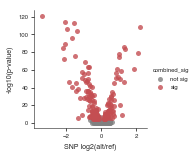

K562
not sig    597
sig         68
Name: combined_sig, dtype: int64


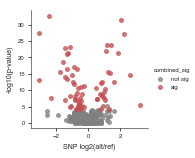

In [42]:
for active_snp_data, cell in zip([hepg2_pool1_active_snp_data, k562_pool1_active_snp_data], ["HepG2", "K562"]):
    print(cell)
    snp_data = active_snp_data[(~active_snp_data["combined_sig"].str.contains("NA")) &
                           (~active_snp_data["unique_id"].str.contains("CONTROL")) &
                           (~active_snp_data["unique_id"].str.contains("HAPLO"))].copy()
    snp_data["combined_neg_log_pval"] = -np.log10(snp_data["combined_pval"].astype(float))
    print(snp_data.combined_sig.value_counts())
    g = sns.lmplot(data=snp_data, x="combined_l2fc", y="combined_neg_log_pval", hue="combined_sig", fit_reg=False,
                   palette=palette, size=2.2, scatter_kws={"s": 25})
    g.set_axis_labels("SNP log2(alt/ref)", "-log10(p-value)")
    plt.show()
    plt.close()
    g.savefig("Fig_S19_%s.pdf" % cell, dpi="figure", bbox_inches="tight")

## 6. make control snp plots (in pool 1)

In [43]:
hepg2_pool1_active_snp_data = hepg2_pool1_active_snp_data.merge(pool1_index_elem[["unique_id", "SNP"]], 
                                                                on="unique_id", how="left")
k562_pool1_active_snp_data = k562_pool1_active_snp_data.merge(pool1_index_elem[["unique_id", "SNP"]], 
                                                              on="unique_id", how="left")
print(len(hepg2_pool1_active_snp_data))
print(len(k562_pool1_active_snp_data))

hepg2_pool1_repressive_snp_data = hepg2_pool1_repressive_snp_data.merge(pool1_index_elem[["unique_id", "SNP"]], 
                                                                        on="unique_id", how="left")
k562_pool1_repressive_snp_data = k562_pool1_repressive_snp_data.merge(pool1_index_elem[["unique_id", "SNP"]], 
                                                                        on="unique_id", how="left")
print(len(hepg2_pool1_repressive_snp_data))
print(len(k562_pool1_repressive_snp_data))

1783
1783
1783
1783


In [44]:
hepg2_pool1_active_sig_data = hepg2_pool1_active_snp_data[hepg2_pool1_active_snp_data["combined_sig"] == "sig"]
hepg2_pool1_repressive_sig_data = hepg2_pool1_repressive_snp_data[hepg2_pool1_repressive_snp_data["combined_sig"] == "sig"]

k562_pool1_active_sig_data = k562_pool1_active_snp_data[k562_pool1_active_snp_data["combined_sig"] == "sig"]
k562_pool1_repressive_sig_data = k562_pool1_repressive_snp_data[k562_pool1_repressive_snp_data["combined_sig"] == "sig"]

In [45]:
hepg2_pool1_snp_data_all = hepg2_pool1_active_snp_data.append(hepg2_pool1_repressive_snp_data)
hepg2_pool1_ctrl_data_all = hepg2_pool1_snp_data_all[hepg2_pool1_snp_data_all["wt_id"].str.contains("CONTROL")]
hepg2_pool1_ctrl_data_all_grp = hepg2_pool1_ctrl_data_all.groupby(["unique_id", "wt_id", "SNP"])["combined_sig"].apply(list).reset_index()

k562_pool1_snp_data_all = k562_pool1_active_snp_data.append(k562_pool1_repressive_snp_data)
k562_pool1_ctrl_data_all = k562_pool1_snp_data_all[k562_pool1_snp_data_all["wt_id"].str.contains("CONTROL")]
k562_pool1_ctrl_data_all_grp = k562_pool1_ctrl_data_all.groupby(["unique_id", "wt_id", "SNP"])["combined_sig"].apply(list).reset_index()

In [46]:
hepg2_pool1_ctrl_snps = hepg2_pool1_active_snp_data[hepg2_pool1_active_snp_data["unique_id"].str.contains("CONTROL")]
k562_pool1_ctrl_snps = k562_pool1_active_snp_data[k562_pool1_active_snp_data["unique_id"].str.contains("CONTROL")]

print(len(hepg2_pool1_ctrl_snps))
print(len(k562_pool1_ctrl_snps))

18
18


In [47]:
hepg2_pool1_ctrl_snps_filt = hepg2_pool1_ctrl_snps[~hepg2_pool1_ctrl_snps["combined_sig"].str.contains("NA")]
k562_pool1_ctrl_snps_filt = k562_pool1_ctrl_snps[~k562_pool1_ctrl_snps["combined_sig"].str.contains("NA")]

In [48]:
hepg2_pool1_data["wt_or_snp"] = hepg2_pool1_data.apply(wt_or_snp, axis=1)
k562_pool1_data["wt_or_snp"] = k562_pool1_data.apply(wt_or_snp, axis=1)

HepG2


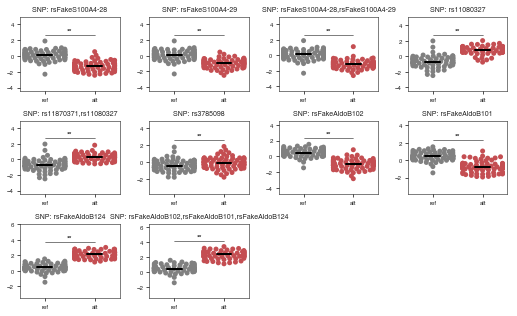

In [49]:
print("HepG2")
paired_swarmplots_w_pval(7, 4, (7.2, 10), hepg2_pool1_ctrl_snps_filt, hepg2_pool1_data, fontsize, ".", "Fig_S16_1", 
                         True)

K562


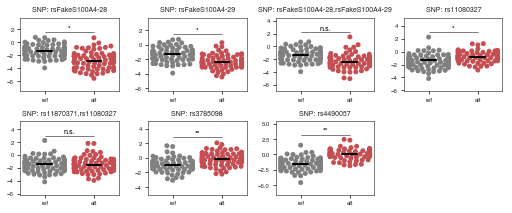

In [50]:
print("K562")
paired_swarmplots_w_pval(7, 4, (7.2, 10), k562_pool1_ctrl_snps_filt, k562_pool1_data, fontsize, ".", "Fig_S16_2", 
                         True)

## 7. make GWAS SNP plots

In [51]:
hepg2_pool1_gwas = hepg2_pool1_active_sig_data[hepg2_pool1_active_sig_data["SNP"].isin(["rs3101018", "rs3785098", "rs4456788"])]
k562_pool1_gwas = k562_pool1_active_sig_data[k562_pool1_active_sig_data["SNP"].isin(["rs3101018", "rs3785098", "rs4456788"])]

HepG2


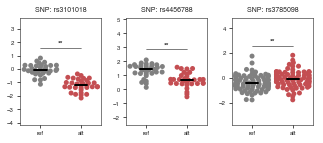

In [52]:
print("HepG2")
paired_swarmplots_w_pval(1, 3, (4.5, 2), hepg2_pool1_gwas, hepg2_pool1_data, fontsize, ".", "Fig_S22_1", True)

K562


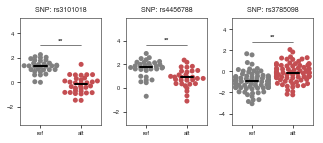

In [53]:
print("K562")
paired_swarmplots_w_pval(1, 3, (4.5, 2), k562_pool1_gwas, k562_pool1_data, fontsize, ".", "Fig_S22_2", True)

## 8. write files

In [54]:
out_dir = "../../data/07__snps"

In [55]:
hepg2_pool2_active_snp_data = hepg2_pool2_active_snp_data.merge(pool2_index_elem[["unique_id", "SNP"]], 
                                                                on="unique_id", how="left")
k562_pool2_active_snp_data = k562_pool2_active_snp_data.merge(pool2_index_elem[["unique_id", "SNP"]], 
                                                              on="unique_id", how="left")

hepg2_pool2_repressive_snp_data = hepg2_pool2_repressive_snp_data.merge(pool2_index_elem[["unique_id", "SNP"]], 
                                                                        on="unique_id", how="left")
k562_pool2_repressive_snp_data = k562_pool2_repressive_snp_data.merge(pool2_index_elem[["unique_id", "SNP"]], 
                                                                      on="unique_id", how="left")

In [56]:
active_dfs = [k562_pool1_active_snp_data, k562_pool2_active_snp_data, hepg2_pool1_active_snp_data, hepg2_pool2_active_snp_data]
repressive_dfs = [k562_pool1_repressive_snp_data, k562_pool2_repressive_snp_data, hepg2_pool1_repressive_snp_data, hepg2_pool2_repressive_snp_data]
all_reps = [k562_pool1_reps, k562_pool2_reps, hepg2_pool1_reps, hepg2_pool2_reps]
cells = ["K562", "K562", "HepG2", "HepG2"]
pools = ["POOL1", "POOL2", "POOL1", "POOL2"]

In [57]:
for active_df, repressive_df, reps, cell, pool in zip(active_dfs, repressive_dfs, all_reps, cells, pools):
    print("%s %s" % (cell, pool))
    col_order = ["unique_id", "wt_id", "SNP"]
    wt_meds = [x + "_wt_med" for x in reps]
    wt_meds.extend(["combined_wt_med"])
    snp_meds = [x + "_snp_med" for x in reps]
    snp_meds.extend(["combined_snp_med"])
    l2fcs = [x + "_l2fc" for x in reps]
    l2fcs.extend(["combined_l2fc"])
    pvals = [x + "_pval" for x in reps]
    pvals.extend(["combined_pval"])
    padjs = [x + "_padj" for x in reps]
    padjs.extend(["combined_padj"])
    sigs = [x + "_sig" for x in reps]
    sigs.extend(["combined_sig"])
    if cell == "HepG2" and pool == "POOL1":
        sigs.extend(["downsamp_sig"])
    
    col_order.extend(wt_meds)
    col_order.extend(snp_meds)
    col_order.extend(l2fcs)
    col_order.extend(pvals)
    col_order.extend(padjs)
    col_order.extend(sigs)
    
    active_df = active_df[col_order]
    repressive_df = repressive_df[col_order]
    
    active_f = "%s/%s__%s_active_snp_results.txt" % (out_dir, cell, pool)
    repressive_f = "%s/%s__%s_repressive_snp_results.txt" % (out_dir, cell, pool)
    
    active_df.to_csv(active_f, sep="\t", index=False)
    repressive_df.to_csv(repressive_f, sep="\t", index=False)

K562 POOL1
K562 POOL2
HepG2 POOL1
HepG2 POOL2


## 9. create nicer table for supplement

In [58]:
hepg2_supp = hepg2_pool1_active_snp_data[["SNP", "unique_id", "combined_wt_med", "combined_snp_med", "combined_l2fc",
                                          "combined_padj", "combined_sig", "downsamp_sig"]]
hepg2_supp.columns = ["SNP", "unique_id", "HepG2_ref_activ", "HepG2_alt_activ", "HepG2_effect_size", "HepG2_padj", 
                      "HepG2_sig_status", "HepG2_downsampled_sig_status"]
hepg2_supp.replace("NA__too_many_rep_NAs", np.nan, inplace=True)
print(len(hepg2_supp))
hepg2_supp.sample(5)

1783


,SNP,unique_id,HepG2_ref_activ,HepG2_alt_activ,HepG2_effect_size,HepG2_padj,HepG2_sig_status,HepG2_downsampled_sig_status
193,rs7164444,WILDTYPE_SNP_INDIV__Antisense.noflip.NA__chr15...,-0.644452,-0.505509,0.138943,1.000000e+00,not sig,not sig
1060,rs1877714,WILDTYPE_SNP_INDIV__mrna.noflip.NA__chr2:21913...,2.161270,1.917629,-0.243641,1.000000e+00,not sig,not sig
1334,rsFakeHBB-29,CONTROL_SNP_INDIV__control.flip.sense__chr11:5...,-1.108018,-1.551207,-0.443189,NaN,NaN,NaN
1510,rs3095337,WILDTYPE_SNP_INDIV__Enhancer.noflip.NA__chr6:3...,2.411389,1.677741,-0.733648,1.845860e-61,sig,sig
331,rs73827419,WILDTYPE_SNP_INDIV__Antisense.noflip.NA__chr3:...,2.619424,2.776576,0.157152,1.000000e+00,not sig,not sig


In [59]:
k562_supp = k562_pool1_active_snp_data[["SNP", "unique_id", "combined_wt_med", "combined_snp_med", "combined_l2fc",
                                        "combined_padj", "combined_sig"]]
k562_supp.columns = ["SNP", "unique_id", "K562_ref_activ", "K562_alt_activ", "K562_effect_size", "K562_padj", 
                     "K562_sig_status"]
k562_supp.replace("NA__too_many_rep_NAs", np.nan, inplace=True)
print(len(k562_supp))
k562_supp.sample(5)

1783


,SNP,unique_id,K562_ref_activ,K562_alt_activ,K562_effect_size,K562_padj,K562_sig_status
974,"rs8062510,rs2270845,rs113086877",WILDTYPE_SNP_PLUS_HAPLO__mrna.noflip.NA__chr16...,3.059020,3.161972,0.102952,1.0,not sig
735,rs140110518,WILDTYPE_SNP_INDIV__mrna.noflip.NA__chr6:13711...,1.555317,1.838828,0.980715,NaN,NaN
447,rs510551,WILDTYPE_SNP_INDIV__Antisense.flip.sense__chr6...,-1.140898,0.912720,2.053618,NaN,NaN
1338,"rs1320976,rs1892092",WILDTYPE_SNP_PLUS_HAPLO__Lincrna.noflip.NA__ch...,-3.261240,-3.416858,-0.155618,NaN,NaN
372,"rs55893519,rs116129283,rs112065591",WILDTYPE_SNP_PLUS_HAPLO__Lincrna.noflip.NA__ch...,1.848832,1.805577,-0.043255,1.0,not sig


In [60]:
supp_table_s7 = hepg2_supp.merge(k562_supp, on=["SNP", "unique_id"]).drop_duplicates()
print(len(supp_table_s7))
supp_table_s7.sample(5)

1783


,SNP,unique_id,HepG2_ref_activ,HepG2_alt_activ,HepG2_effect_size,HepG2_padj,HepG2_sig_status,HepG2_downsampled_sig_status,K562_ref_activ,K562_alt_activ,K562_effect_size,K562_padj,K562_sig_status
1396,rs12681880,WILDTYPE_SNP_INDIV__Enhancer.noflip.NA__chr8:1...,-1.537991,-2.044524,-0.506534,NaN,NaN,NaN,-2.874103,-3.168794,-0.294691,NaN,NaN
616,rs17171772,WILDTYPE_SNP_INDIV__mrna.flip.sense__chr5:1375...,-0.647637,-0.695957,-0.048319,1.0,not sig,not sig,-2.181802,-2.144277,0.037524,NaN,NaN
173,rs79436692,WILDTYPE_SNP_INDIV__Antisense.flip.sense__chr1...,1.204733,1.148033,-0.056699,1.0,not sig,not sig,1.361629,1.113008,-0.248621,1.0,not sig
1386,rs192987417,WILDTYPE_SNP_INDIV__Enhancer.noflip.NA__chr3:1...,-0.303878,-0.315071,-0.011192,1.0,not sig,not sig,-1.612627,-1.597283,0.015344,NaN,NaN
866,rs3802967,WILDTYPE_SNP_INDIV__mrna.noflip.NA__chr11:1834...,1.707067,1.899001,0.191934,1.0,not sig,not sig,0.654441,0.707474,0.053033,1.0,not sig


In [61]:
supp_table_s7.to_csv("%s/Supplemental_Table_S7.txt" % out_dir, sep="\t", index=False)

## 10. correlate SNPs with fimo motif predictions

In [62]:
def reverse_snp_map(snp_map):
    rev_map = {}
    for key in snp_map:
        vals = snp_map[key][0]
        for val in vals:
            if val not in rev_map:
                rev_map[val] = key
            else:
                print("dupe val: %s" % val)
    return rev_map

In [63]:
hepg2_pool1_rev_map = reverse_snp_map(hepg2_pool1_snp_map)
k562_pool1_rev_map = reverse_snp_map(k562_pool1_snp_map)

In [64]:
fimo.set_index("seqID", inplace=True)
fimo.head()

,n_motifs
seqID,
"CONTROL_BUT_HAS_SNP__control.flip.sense__chr11:5248266..5248380,-__1715.1.0.0",10
"CONTROL_BUT_HAS_SNP__control.flip.sense__chr16:67993585..67993700,+__2318.1.0.0",50
"CONTROL_BUT_HAS_SNP__control.flip.sense__chr17:33571488..33571603,+__2316.1.0.0",24
"CONTROL_BUT_HAS_SNP__control.flip.sense__chr17:76375037..76375152,+__2319.1.0.0",12
"CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:153518247..153518361,-__1714.1.0.0",16


In [65]:
fimo_dict = fimo.to_dict(orient="index")

In [66]:
def get_snp_tfbs_delta(row, rev_map, fimo_map):
    try:
        n_wt_tfs = fimo_map[rev_map[row["unique_id"]]]["n_motifs"]
        n_snp_tfs = fimo_map[row["unique_id"]]["n_motifs"]
    except:
        n_wt_tfs = np.nan
        n_snp_tfs = np.nan
    delta_tfs = n_snp_tfs - n_wt_tfs
    return delta_tfs

In [67]:
supp_table_s7["delta_tfs"] = supp_table_s7.apply(get_snp_tfbs_delta, rev_map=hepg2_pool1_rev_map, 
                                                 fimo_map=fimo_dict, axis=1)
supp_table_s7.sample(5)

,SNP,unique_id,HepG2_ref_activ,HepG2_alt_activ,HepG2_effect_size,HepG2_padj,HepG2_sig_status,HepG2_downsampled_sig_status,K562_ref_activ,K562_alt_activ,K562_effect_size,K562_padj,K562_sig_status,delta_tfs
1386,rs192987417,WILDTYPE_SNP_INDIV__Enhancer.noflip.NA__chr3:1...,-0.303878,-0.315071,-0.011192,1.000000,not sig,not sig,-1.612627,-1.597283,0.015344,NaN,NaN,-1.0
1281,"rs113733106,rs1032577",WILDTYPE_SNP_PLUS_HAPLO__mrna.noflip.NA__chr8:...,-0.192584,-0.503481,-0.310896,0.003901,sig,not sig,-0.613125,-1.021966,-0.408841,1.0,not sig,-5.0
714,rs740531,WILDTYPE_SNP_INDIV__mrna.noflip.NA__chr7:72220...,1.967938,2.214626,0.246688,1.000000,not sig,not sig,2.484431,2.476347,-0.008084,1.0,not sig,0.0
1042,rs4302219,WILDTYPE_SNP_INDIV__mrna.noflip.NA__chr2:11188...,-0.066740,0.840933,0.907673,NaN,NaN,NaN,-0.816565,2.338172,3.154737,NaN,NaN,-1.0
982,rs62066869,WILDTYPE_SNP_INDIV__mrna.noflip.NA__chr17:2005...,-0.216900,-0.244970,-0.028071,NaN,NaN,NaN,0.538531,0.198968,-0.339563,NaN,NaN,0.0


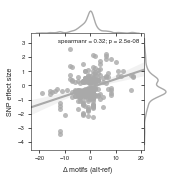

In [68]:
df = supp_table_s7[supp_table_s7["HepG2_sig_status"] == "sig"]
g = sns.jointplot(data=df, x="delta_tfs", y="HepG2_effect_size", kind="reg", space=0, size=2.5, stat_func=spearmanr, 
                  marginal_kws={"hist": False}, color="darkgrey", scatter_kws={"s": 25})
g.set_axis_labels(r"$\Delta$ motifs (alt-ref)", "SNP effect size")
g.savefig("Fig_5B.pdf", dpi="figure", bbox_inches="tight")

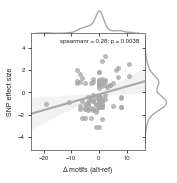

In [69]:
df = supp_table_s7[supp_table_s7["K562_sig_status"] == "sig"]
g = sns.jointplot(data=df, x="delta_tfs", y="K562_effect_size", kind="reg", space=0, size=2.5, stat_func=spearmanr, 
                  marginal_kws={"hist": False}, color="darkgrey", scatter_kws={"s": 25})
g.set_axis_labels(r"$\Delta$ motifs (alt-ref)", "SNP effect size")
g.savefig("Fig_S18.pdf", dpi="figure", bbox_inches="tight")

## 11. correlate SNPs across cell types

In [70]:
def both_type(row):
    if row["HepG2_downsampled_sig_status"] == "sig" and row["K562_sig_status"] == "sig":
        return "sig in both"
    elif row["HepG2_downsampled_sig_status"] == "sig" and row["K562_sig_status"] == "not sig":
        return "sig in HepG2"
    elif row["HepG2_downsampled_sig_status"] == "not sig" and row["K562_sig_status"] == "sig":
        return "sig in K562"
    else:
        return "not sig in both"
    
supp_table_s7["sig_type"] = supp_table_s7.apply(both_type, axis=1)
supp_table_s7.sample(5)

,SNP,unique_id,HepG2_ref_activ,HepG2_alt_activ,HepG2_effect_size,HepG2_padj,HepG2_sig_status,HepG2_downsampled_sig_status,K562_ref_activ,K562_alt_activ,K562_effect_size,K562_padj,K562_sig_status,delta_tfs,sig_type
1650,rs2941540,WILDTYPE_SNP_INDIV__Enhancer.noflip.NA__chr7:4...,-1.199157,-0.953319,0.245839,NaN,NaN,NaN,-0.057399,0.218700,0.276099,1.000000e+00,not sig,5.0,not sig in both
873,rs2074038,WILDTYPE_SNP_INDIV__mrna.noflip.NA__chr11:4408...,0.443732,1.495436,1.051704,1.804997e-47,sig,sig,-0.663571,1.906792,2.570364,1.186220e-12,sig,11.0,sig in both
1283,rs2294008,WILDTYPE_SNP_INDIV__mrna.noflip.NA__chr8:14376...,-1.411385,-1.254887,0.156498,NaN,NaN,NaN,-3.271722,-2.655792,0.615930,NaN,NaN,-1.0,not sig in both
797,rs2071225,WILDTYPE_SNP_INDIV__mrna.noflip.NA__chrX:10066...,-0.189871,-0.862628,-0.672757,2.791191e-27,sig,sig,-0.651362,-1.719718,-1.068356,3.342908e-03,sig,-1.0,sig in both
760,"rs10276377,rs11772456,rs10233067",WILDTYPE_SNP_PLUS_HAPLO__mrna.noflip.NA__chr7:...,-0.090059,0.033238,0.123297,1.000000e+00,not sig,not sig,1.101819,1.133297,0.031478,1.000000e+00,not sig,1.0,not sig in both


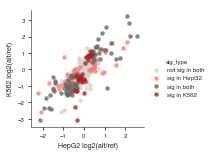

In [71]:
both_no_null = supp_table_s7[~pd.isnull(supp_table_s7["HepG2_sig_status"]) & ~pd.isnull(supp_table_s7["K562_sig_status"])]
palette = {"not sig in both": "lightgrey", "sig in both": "dimgrey", 
           "sig in HepG2": "salmon", "sig in K562": "firebrick"}
g = sns.lmplot(data=both_no_null, x="HepG2_effect_size", y="K562_effect_size", fit_reg=False, hue="sig_type",
               palette=palette, size=2.2, scatter_kws={"s": 20})
g.set_axis_labels("HepG2 log2(alt/ref)", "K562 log2(alt/ref)")
g.savefig("Fig_4C.pdf", dpi="figure", bbox_inches="tight")

In [72]:
both_no_null.sig_type.value_counts()

not sig in both    655
sig in both         72
sig in HepG2        63
sig in K562         33
Name: sig_type, dtype: int64

## 12. compare results using all HepG2 reps vs. subset

In [73]:
hepg2_all_sig = len(supp_table_s7[supp_table_s7["HepG2_sig_status"] == "sig"])
hepg2_down_sig = len(supp_table_s7[supp_table_s7["HepG2_downsampled_sig_status"] == "sig"])

In [74]:
rep_nums = {"HepG2 (Sampled Replicates: 4)": [4, hepg2_down_sig], "HepG2 (All Replicates: 12)": [12, hepg2_all_sig]}
rep_nums = pd.DataFrame.from_dict(rep_nums, orient="index").reset_index()
rep_nums.columns = ["name", "reps", "snps"]
rep_nums.head()

,name,reps,snps
0,HepG2 (Sampled Replicates: 4),4,161
1,HepG2 (All Replicates: 12),12,289


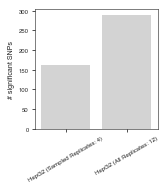

In [75]:
fig = plt.figure(figsize=(2.2, 2.2))
ax = sns.barplot(data=rep_nums, x="name", y="snps", color="lightgray")
ax.set_xlabel("")
ax.set_ylabel("# significant SNPs")
ax.set_xticklabels(["HepG2 (Sampled Replicates: 4)", "HepG2 (All Replicates: 12)"], rotation=30)
fig.savefig("Fig_S20B.pdf", dpi="figure", bbox_inches="tight")

## 13. compare effect sizes across biotypes

In [76]:
supp_table_s7 = supp_table_s7.merge(annot, left_on="unique_id", right_on="seqID")
supp_table_s7.head()

,SNP,unique_id,HepG2_ref_activ,HepG2_alt_activ,HepG2_effect_size,HepG2_padj,HepG2_sig_status,HepG2_downsampled_sig_status,K562_ref_activ,K562_alt_activ,K562_effect_size,K562_padj,K562_sig_status,delta_tfs,sig_type,seqID,PromType2
0,rs4970820,WILDTYPE_SNP_INDIV__Lincrna.flip.sense__chr1:1...,2.432022,2.363694,-0.068328,1.0,not sig,not sig,2.464316,2.402414,-0.061902,1.0,not sig,-9.0,not sig in both,WILDTYPE_SNP_INDIV__Lincrna.flip.sense__chr1:1...,intergenic
1,rs60844753,WILDTYPE_SNP_INDIV__Antisense.flip.sense__chr1...,-0.513299,-0.310393,0.202906,NaN,NaN,NaN,-0.401422,-0.193217,0.208205,NaN,NaN,0.0,not sig in both,WILDTYPE_SNP_INDIV__Antisense.flip.sense__chr1...,div_lnc
2,rs60844753,WILDTYPE_SNP_INDIV__Antisense.noflip.NA__chr1:...,-0.962268,-0.978317,-0.016049,1.0,not sig,not sig,-2.478924,-2.779746,-0.300823,NaN,NaN,0.0,not sig in both,WILDTYPE_SNP_INDIV__Antisense.noflip.NA__chr1:...,div_lnc
3,rs115274951,WILDTYPE_SNP_INDIV__Antisense.noflip.NA__chr1:...,2.914807,2.991548,0.076741,1.0,not sig,not sig,2.478906,2.455319,-0.023587,1.0,not sig,-6.0,not sig in both,WILDTYPE_SNP_INDIV__Antisense.noflip.NA__chr1:...,intergenic
4,rs1555794,WILDTYPE_SNP_INDIV__Antisense.noflip.NA__chr1:...,-0.552470,-0.540787,0.011684,1.0,not sig,not sig,-1.685674,-1.057917,0.627757,NaN,NaN,-3.0,not sig in both,WILDTYPE_SNP_INDIV__Antisense.noflip.NA__chr1:...,div_lnc


In [77]:
supp_table_s7["HepG2_abs_effect_size"] = np.abs(supp_table_s7["HepG2_effect_size"])
supp_table_s7["K562_abs_effect_size"] = np.abs(supp_table_s7["K562_effect_size"])

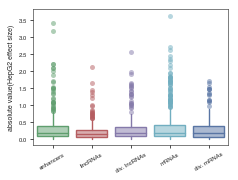

In [78]:
fig = plt.figure(figsize=(3.5, 2.5))
ax = sns.boxplot(data=supp_table_s7, x="PromType2", y="HepG2_abs_effect_size", 
                 flierprops = dict(marker='o', markersize=5), order=TSS_CLASS_ORDER, palette=TSS_CLASS_PALETTE)
ax.set_xticklabels(["enhancers", "lincRNAs", "div. lncRNAs", "mRNAs", "div. mRNAs"], rotation=30)
mimic_r_boxplot(ax)
plt.xlabel("")
plt.ylabel("absolute value(HepG2 effect size)")
fig.savefig("Fig_S21_1.pdf", dpi="figure", bbox_inches="tight")

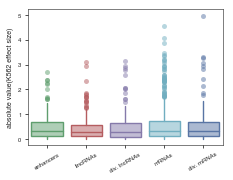

In [79]:
fig = plt.figure(figsize=(3.5, 2.5))
ax = sns.boxplot(data=supp_table_s7, x="PromType2", y="K562_abs_effect_size", 
                 flierprops = dict(marker='o', markersize=5), order=TSS_CLASS_ORDER, palette=TSS_CLASS_PALETTE)
ax.set_xticklabels(["enhancers", "lincRNAs", "div. lncRNAs", "mRNAs", "div. mRNAs"], rotation=30)
mimic_r_boxplot(ax)
plt.xlabel("")
plt.ylabel("absolute value(K562 effect size)")
fig.savefig("Fig_S21_2.pdf", dpi="figure", bbox_inches="tight")